In [1]:
%set_env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [2]:
from tqdm.auto import tqdm, trange
import numpy as np

TASK = "mrpc"
POOLING_STRATEGY="CLS"

In [3]:
import transformers

import torch
from collections import defaultdict
# model base
import utils.models
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.models.roberta.modeling_roberta import RobertaForSequenceClassification

In [20]:
# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

In [21]:
# model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", 
                                                     #  output_hidden_states=True, 
                                                     # )
model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", 
                                                      output_hidden_states=True, 
                                                     )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Mean Pooling - Take attention mask into account for correct averaging
# output -- exact hidden layer
def mean_pooling(output, attention_mask):
    token_embeddings = output
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [5]:
# output is actual model output class
def first_last_pooling(output, attention_mask):

    batched = zip(*[torch.split(mean_pooling(x, attention_mask), 1) for x in [output.hidden_states[0], output.hidden_states[-1]]])

    averaged_layers = torch.cat([torch.cat(layers, dim=0).mean(dim=0, keepdim=True) \
                                  for layers in batched], dim=0)

    return averaged_layers

In [6]:
def get_sentence_embeddings(output, attention_mask):

    return {"cls/first": output.hidden_states[-1][:, 0, :], 
            "avg_pool": mean_pooling(output.hidden_states[-1], attention_mask),
            "mul_layer_pool": first_last_pooling(output, attention_mask)}

In [7]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

In [8]:
from datasets import load_dataset

dataset = load_dataset("nyu-mll/glue", TASK)

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

### Visual recognition

In [10]:
def get_emb_matrix(model, tokenizer, dataset, ):

    emb_classwise = {}
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, drop_last=True, num_workers=6,)
    
    for batch in tqdm(dataloader):
        
        sent1, sent2 = task_to_keys[TASK]
        lbl = batch["label"].item()

        text_feats = (batch[sent1], ) if sent2 is None else (batch[sent1], batch[sent2])

        inputs = tokenizer(*text_feats, truncation=True, 
                   max_length=tokenizer.model_max_length, padding=True,
                  return_tensors="pt")

        with torch.no_grad():
            result = get_sentence_embeddings(model(**inputs, output_hidden_states=True), inputs["attention_mask"])
        
        if emb_classwise.get(lbl, None) is None:
            emb_classwise[lbl] = result
        else:
            for k in emb_classwise[lbl]:
                emb_classwise[lbl][k] = torch.cat((emb_classwise[lbl][k], result[k]), dim=0)

    flipped = defaultdict(dict)
    for k, v in emb_classwise.items():
        for sk, sv in v.items():
            flipped[sk][k] = sv - sv.mean(axis=0)
    
    
    return flipped

In [11]:
from sklearn.decomposition import KernelPCA, TruncatedSVD
from umap import UMAP
import matplotlib.pyplot as plt

In [12]:
k_pca = KernelPCA(n_components=3, kernel="cosine", )

t_svd = TruncatedSVD(n_components=3, )

umap = UMAP(n_components=3, metric="euclidean")

In [13]:
def get_low_dim_embs(vecs):
    
    sp_pca_embs_0, sp_pca_embs_1 = k_pca.fit_transform(vecs[0]),  k_pca.transform(vecs[1])
    t_svd_embs_0, t_svd_embs_1 = t_svd.fit_transform(vecs[0]), t_svd.transform(vecs[1])
    umap_embs_0, umap_embs_1 = umap.fit_transform(vecs[0]), umap.transform(vecs[1]) 

    return sp_pca_embs_0, sp_pca_embs_1, t_svd_embs_0,  t_svd_embs_1, umap_embs_0, umap_embs_1

In [14]:
def plot_3d(embs, pts_num: int):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": '3d'}, figsize = (12, 10))
    
    ax1.scatter(*np.random.permutation(embs[0])[:pts_num, :].T,)
    ax1.scatter(*np.random.permutation(embs[1])[:pts_num, :].T,)
    ax1.set_title("Kernel PCA")
    
    ax2.scatter(*np.random.permutation(embs[2])[:pts_num, :].T,)
    ax2.scatter(*np.random.permutation(embs[3])[:pts_num, :].T,)
    ax2.set_title("Truncated SVD")
    ax2.set_title("Truncated SVD")
    
    ax3.scatter(*np.random.permutation(embs[4])[:pts_num, :].T, )
    ax3.scatter(*np.random.permutation(embs[5])[:pts_num, :].T, )
    ax3.set_title("UMAP")
    
    plt.show()
    

In [15]:
def print_stats(embs):

    from utils.training_utils import compute_anisotropy # intrinsic_dimension

    

    for name, emb in embs.items():
        print(f'{name}: {", ".join([f"{x:.3f}" for x in compute_anisotropy(torch.cat(tuple(emb.values()), dim=0), n_components=5, write_to_file=None)])},')
        for key, group_emb in emb.items():
            print(f'{name}: anisotropy class {key} -- {", ".join([f"{x:.3f}" for x in compute_anisotropy(group_emb, n_components=5, write_to_file=None)])},') 
        # dimension -- {intrinsic_dimension(emb):.3f}
    return None

In [16]:
def draw_distribution(embs):

    from utils.training_utils import compute_anisotropy

    for name, emb in embs.items():
        plt.plot(compute_anisotropy(emb, n_components="all", write_to_file=None), label=name)
        plt.legend(loc="upper right")
        

In [17]:
def cleanup():
    import gc

    gc.collect()
    torch.cuda.empty_cache()

### No training

In [22]:
emb_matrix = get_emb_matrix(model, tokenizer, dataset["validation"])

  0%|          | 0/408 [00:00<?, ?it/s]

In [24]:
cls_embs = get_low_dim_embs(emb_matrix["cls/first"])
avg_embs = get_low_dim_embs(emb_matrix["avg_pool"])
mul_layer_embs = get_low_dim_embs(emb_matrix["mul_layer_pool"])

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


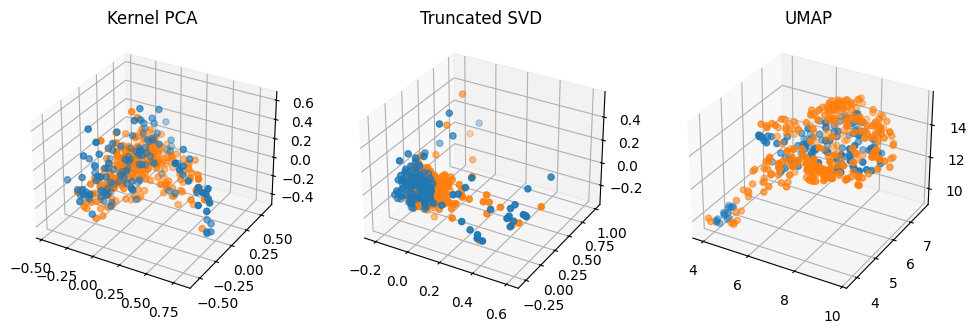

In [25]:
plot_3d(cls_embs, None)

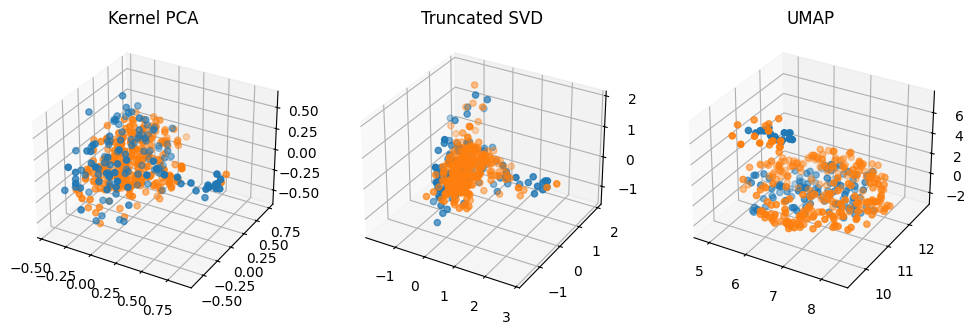

In [26]:
plot_3d(avg_embs, None)

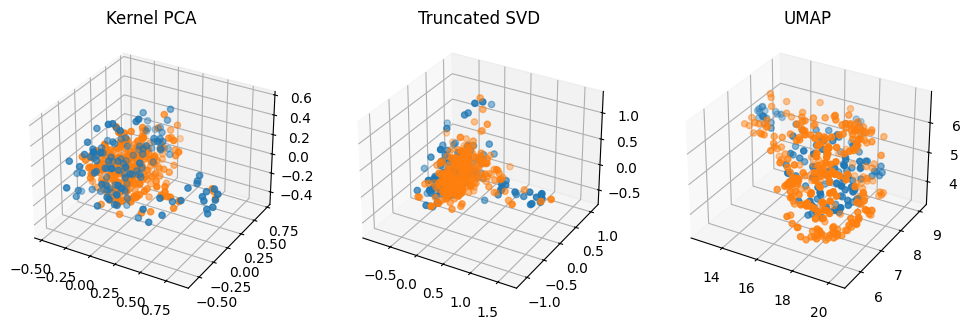

In [27]:
plot_3d(mul_layer_embs, None)

In [28]:
cleanup()

### Prototyping finetuning

In [ ]:
import multiprocessing as mp
from tqdm import trange
from tqdm.auto import tqdm
from utils import training_utils
import ast
import wandb

wandb.login()

#mp.set_start_method('spawn')

In [20]:
cont_embedding_factory = {"CLS": lambda x, _: x.hidden_states[-1][:, 0, :],
                          "AVG": lambda x, attention_mask: mean_pooling(x.hidden_states[-1], attention_mask),
                          "MUL_AVG": lambda x, attention_mask: first_last_pooling(x, attention_mask)}

static_embedding_factory = {"CLS": lambda x, _: x.hidden_states[0][:, 0, :],
                          "AVG": lambda x, attention_mask: mean_pooling(x.hidden_states[0], attention_mask),}

In [21]:
BATCH_SIZE = 8
MAX_LENGTH = 512
NUM_EPOCH, ACCUM_ITER = 10, 8
USE_FP16 = True

STAT_EMB_TYPE = "CLS"

USE_ENTROPY_STATIC = False

USE_PROMINIENT_FEATURES_STATIC = False

get_static_mean_embedding = static_embedding_factory[STAT_EMB_TYPE]

device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [27]:
import pathlib
path = pathlib.Path(f"./logs/{TASK}_roberta_l2_only")

In [28]:
path.mkdir(parents=True, exist_ok=True)

In [29]:
def get_anisotropy_dict(path,):

    files = [
        # path.joinpath(f"anisotropy.log"),
        # path.joinpath(f"anisotropy_centered.log"),
             path.joinpath(f"cont_anisotropy.log"),
             path.joinpath(f"cont_anisotropy_centered.log"),
    ]

    ani_dict = {}

    for file in files:
        res = ast.literal_eval(training_utils.get_last_line(file))
        try:
            for i, val in enumerate(res):
                ani_dict[f"{file.stem}_{i}"] = float(val)
        except:
            pass
    return ani_dict

In [30]:
def tokenize_dataset(elem):

    text1, text2 = task_to_keys[TASK]

    text_feats = (elem[text1], ) if text2 is None else (elem[text1], elem[text2])

    encoded = tokenizer(*text_feats, padding=True, max_length=MAX_LENGTH, truncation=True)
    encoded["labels"] = elem["label"]
    return encoded    

In [31]:
tokenized_dataset = dataset.map(tokenize_dataset,
                     batched=True,
                     desc="Running tokenizer",
                     remove_columns=dataset["train"].column_names)

In [32]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 408
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1725
    })
})

In [33]:
from transformers import default_data_collator, DataCollatorWithPadding

PAD_TO_MAX_LENGTH = False

if PAD_TO_MAX_LENGTH:
    data_collator = default_data_collator
else:
    data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=(8 if USE_FP16 else None))

In [34]:
dataloader = torch.utils.data.DataLoader(tokenized_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=3, collate_fn=data_collator, drop_last=True)

In [35]:
dataloader_eval = torch.utils.data.DataLoader(tokenized_dataset["validation"], batch_size=BATCH_SIZE, shuffle=True, num_workers=3, collate_fn=data_collator, drop_last=True)

In [36]:
from transformers import get_cosine_schedule_with_warmup
import math

LR = 8e-5
WEIGHT_DECAY = 8e-6
NUM_TRAINING_STEPS=math.floor(len(dataloader)/ACCUM_ITER*NUM_EPOCH)
NUM_WARMUP_STEPS=int(0.1*NUM_TRAINING_STEPS)


In [37]:
len(dataloader)

458

In [38]:
TEST_EVERY = 200

In [39]:
def configure_optimizers(model, lr: float, weight_decay: float):
    """
    This long function is unfortunately doing something very simple and is being very defensive:
    We are separating out all parameters of the model into two buckets: those that will experience
    weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
    We are then returning the PyTorch optimizer object.
    """

    # separate out all parameters to those that will and won't experience regularizing weight decay
    decay = set()
    no_decay = set()
    whitelist_weight_modules = (torch.nn.Linear, )
    blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
    for mn, m in model.named_modules():
        for pn, p in m.named_parameters():
            fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

            if pn.endswith('bias'):
                # all biases will not be decayed
                no_decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                # weights of whitelist modules will be weight decayed
                decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                # weights of blacklist modules will NOT be weight decayed
                no_decay.add(fpn)

    # special case the position embedding parameter in the root GPT module as not decayed
    #no_decay.add('pos_emb')

    # validate that we considered every parameter
    param_dict = {pn: p for pn, p in model.named_parameters()}
    inter_params = decay & no_decay
    union_params = decay | no_decay
    assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
    assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                % (str(param_dict.keys() - union_params), )

    # create the pytorch optimizer object
    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
    ]
    optimizer = torch.optim.AdamW(optim_groups, lr=lr, )
    return optimizer

In [40]:
def evaluate_model(path, model, dl_eval, metric,):

    model.eval()
    for step, batch in enumerate(dl_eval):

        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = predictions, batch["labels"]
        
        metric.add_batch(
            predictions=predictions,
            references=references,
        )

    eval_metric = metric.compute()
    wandb.log({"Eval_metric": eval_metric})

    with open(path.joinpath(f"metric.eval"), "a") as f:
        print(eval_metric, file=f, end="\n")

    model.train()
    return

### Define model

In [41]:
from evaluate import load

def repetitive_training(path=path, dataloader=dataloader, dataloader_eval=dataloader_eval, num_iter = 5, TEST_EVERY=5000):

    cont_embedding_factory = {"CLS": lambda x, _: x.hidden_states[-1][:, 0, :],
                          "AVG": lambda x, attention_mask: mean_pooling(x.hidden_states[-1], attention_mask),
                          "MUL_AVG": lambda x, attention_mask: first_last_pooling(x, attention_mask)}

    def setup_and_train(path, USE_ENTROPY, CONT_EMB_TYPE, USE_PROMINIENT_FEATURES, ITER, TEST_EVERY):

        get_contextual_mean_embedding = cont_embedding_factory[CONT_EMB_TYPE]
        
        
        # model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", 
                                                             #  output_hidden_states=True, 
                                                             # )
        model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", 
                                                              output_hidden_states=True, 
                                                             )

        optim = configure_optimizers(model, lr=LR, weight_decay=WEIGHT_DECAY)

        lr_scheduler = get_cosine_schedule_with_warmup(optim, 
                                           num_warmup_steps=NUM_WARMUP_STEPS, 
                                           num_training_steps=NUM_TRAINING_STEPS)


        glue_metric = load('glue', TASK)

        name = f"roberta_base_{TASK}_{USE_ENTROPY}_{CONT_EMB_TYPE}_{USE_PROMINIENT_FEATURES}_{ITER}_l2_only"
        # name = f"bert_base_{TASK}_{USE_ENTROPY}_{CONT_EMB_TYPE}_{USE_PROMINIENT_FEATURES}_{ITER}"

        local_path = path.joinpath(name)
        local_path.mkdir(exist_ok=True, parents=True)

        wandb.init(project="isoBERT_iterative", 
                   name=name,
                   config={"learning_rate": LR, 
                             "weight_decay": WEIGHT_DECAY,
                             "warmup_steps": NUM_WARMUP_STEPS,
                             "epochs": NUM_EPOCH,
                             "batch_size": BATCH_SIZE,
                             "gradient_accumulation": ACCUM_ITER,
                             "max_length": MAX_LENGTH,
                             "entropy_pooling": CONT_EMB_TYPE,
                             "entropy_static_pooling": STAT_EMB_TYPE,
                             "use_entropy": USE_ENTROPY,
                             "prom_features_only": USE_PROMINIENT_FEATURES}
                  )

        device = "cuda" if torch.cuda.is_available() else "cpu"

        cleanup()

        model = model.to(device)

        train(path=local_path, model=model, dl_train=dataloader, 
              dl_eval=dataloader_eval, metric=glue_metric,
              optim=optim, scheduler=lr_scheduler, NUM_EPOCH=NUM_EPOCH, ACCUM_ITER=ACCUM_ITER,
              use_entropy_cont=USE_ENTROPY, use_prominient_features_cont=USE_PROMINIENT_FEATURES, 
              TEST_EVERY=TEST_EVERY, device=device, get_contextual_mean_embedding=get_contextual_mean_embedding)


        model = model.to("cpu")

        model.save_pretrained(f"models/{name}") # seems not to be needed for now
        return
        

    # cont_emb_types = ["CLS", "AVG"]
    cont_emb_types = ["CLS"]
    #uses_entropy = [False, True]
    uses_entropy = [True]
    #use_prominient_features_conts = [False,True] 
    use_prominient_features_conts = [True] 

    for USE_ENTROPY in uses_entropy:
        if USE_ENTROPY:
            for CONT_EMB_TYPE in cont_emb_types:
                for USE_PROMINIENT_FEATURES in use_prominient_features_conts:
                    for ITER in range(num_iter):
        
                        setup_and_train(path=path,
                                       USE_ENTROPY=USE_ENTROPY, 
                                       CONT_EMB_TYPE=CONT_EMB_TYPE,
                                       USE_PROMINIENT_FEATURES=USE_PROMINIENT_FEATURES,
                                       ITER=ITER, TEST_EVERY=TEST_EVERY)
        
        else:

            CONT_EMB_TYPE, USE_PROMINIENT_FEATURES = "CLS", False
            
            for ITER in range(num_iter):
                
                setup_and_train(path=path,
                    USE_ENTROPY=USE_ENTROPY, 
                    CONT_EMB_TYPE=CONT_EMB_TYPE,
                    USE_PROMINIENT_FEATURES=USE_PROMINIENT_FEATURES,
                    ITER=ITER, TEST_EVERY=TEST_EVERY)
            
    return "Done"     

In [42]:
def train(path, model, dl_train, dl_eval, metric, optim, scheduler, NUM_EPOCH, 
          ACCUM_ITER, get_contextual_mean_embedding, use_entropy_static=False, use_prominient_features_static=False,
         use_entropy_cont=True, use_prominient_features_cont=True, TEST_EVERY=TEST_EVERY, device=device,):

    tq_epoch = trange(NUM_EPOCH, desc='Epochs: ')
    tq_batch = tqdm(total=len(dl_train)//ACCUM_ITER)
    batch_loss, entropy_loss, pers_feats = 0, 0, 0
    emb_matrix, cont_emb_matrix, labels = None, None, None
    l2_lambda = torch.tensor(0.05, device=device, requires_grad=True)
    

    for epoch in tq_epoch:
        tq_batch.reset()
        model.train()
            # loop through enumaretad batches
        for batch_idx, batch in enumerate(dl_train):

            if (batch_idx+1) % TEST_EVERY == 0:
                evaluate_model(path, model, dl_eval, metric,)

            inputs = {k: v.to(device) for k, v in batch.items()}
            
            # passes and weights update
            with torch.set_grad_enabled(True):
                # forward pass
                preds = model(**inputs, output_hidden_states=True)
                loss = preds.loss
                #embeddings = get_static_mean_embedding(preds, inputs["attention_mask"])
                cont_embeddings = get_contextual_mean_embedding(preds, inputs["attention_mask"])
                
                # if emb_matrix is None:
                #     emb_matrix = embeddings
                # else:
                #     emb_matrix = torch.cat((emb_matrix, embeddings), dim=0)

                if cont_emb_matrix is None:
                    cont_emb_matrix = cont_embeddings
                else:
                    cont_emb_matrix = torch.cat((cont_emb_matrix, cont_embeddings), dim=0)

                if labels is None:
                    labels = batch["labels"]
                else:
                    labels = torch.cat((labels, batch["labels"]))
        
                # normalize loss to account for batch accumulation
                loss = loss / ACCUM_ITER
                batch_loss += loss.detach().cpu().item()

                # weights update
                if ((batch_idx + 1) % ACCUM_ITER == 0) or (batch_idx + 1 == len(dl_train)):
                    # matrix = matrix.flatten(0, 1)
                    # mp.Process(target=training_utils.compute_anisotropy, 
                    #               kwargs={"matrix": emb_matrix.detach().cpu(),
                    #                       "write_to_file": path.joinpath(f"anisotropy.log")},
                    #              daemon=True).start()
                    # mp.Process(target=training_utils.compute_anisotropy, 
                    #               kwargs={"matrix": emb_matrix.detach().cpu() - emb_matrix.detach().cpu().mean(dim=0),
                    #                       "write_to_file": path.joinpath(f"anisotropy_centered.log")},
                    #              daemon=True).start()
                    mp.Process(target=training_utils.compute_anisotropy, 
                                  kwargs={"matrix": cont_emb_matrix.detach().cpu(),
                                          "write_to_file": path.joinpath(f"cont_anisotropy.log")},
                                 daemon=True).start()
                    mp.Process(target=training_utils.compute_anisotropy, 
                                  kwargs={"matrix": cont_emb_matrix.detach().cpu() - cont_emb_matrix.detach().cpu().mean(dim=0),
                                          "write_to_file": path.joinpath(f"cont_anisotropy_centered.log")},
                                 daemon=True).start()

                    if (use_entropy_static | use_entropy_cont):          
                        if use_entropy_static: 
                            for val in labels.unique(): #  embeddings labelwise
    
                                ent_loss, num_features = training_utils.entropy_loss(emb_matrix[labels == val], max_dim=1, 
                                                                                 use_prominient_features=use_prominient_features_static, 
                                                                                     l2_lambda=l2_lambda) 
                                pers_feats += num_features
                                entropy_loss -= ent_loss
    
                        if use_entropy_cont:
                            for val in labels.unique():
                                
                                ent_loss, num_features = training_utils.entropy_loss(cont_emb_matrix[labels == val], max_dim=1, 
                                                                     use_prominient_features=use_prominient_features_cont, 
                                                                                     l2_lambda=l2_lambda) 
                                pers_feats += num_features
                                entropy_loss -= ent_loss
                                
                        (entropy_loss + loss).backward()
                    else:
                        loss.backward()
                        ent_loss, pers_feats = 0, 0
                    
                    grad_norm = training_utils.gradient_norm(model)
                    anisotropy_dict = get_anisotropy_dict(path)
                    
                    
                    
                    optim.step()
                    local_lr = scheduler.get_lr()[0]
                    scheduler.step()
                    optim.zero_grad()    

                    wandb.log(
                    {"Epoch": epoch,
                     "lr": float(local_lr),
                   "Pred loss": batch_loss,
                   "entropy loss": ent_loss,
                   "pers_features": pers_feats,
                   "grad norm": grad_norm,
                    "l2_lambda": l2_lambda.item(),
                     **anisotropy_dict,
                    })
                    emb_matrix, cont_emb_matrix, labels = None, None, None
                    batch_loss, entropy_loss, pers_feats = 0, 0, 0

                    tq_batch.update(1)

                    # handle for last small batches
                    if (len(dl_train) - batch_idx) < ACCUM_ITER:
                        tq_batch.update(1)
                        break
                else:
                    loss.backward(retain_graph=True)


        # once every epoch
        evaluate_model(path=path, model=model, dl_eval=dl_eval, metric=metric, )
    
#       if epoch+1 % SAVE_EPOCH == 0:
        # Note -- we don't save the model class, only the weights
#            save_model(epoch, model, optim, pred, total_loss)

    model.eval();
    return None

In [43]:
device

'cuda'

In [44]:
path, TEST_EVERY

(PosixPath('logs/mrpc_roberta_l2_only'), 200)

In [45]:
repetitive_training(path=path, dataloader=dataloader, dataloader_eval=dataloader_eval, num_iter=1, TEST_EVERY=TEST_EVERY)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epochs: 100%|██████████| 10/10 [19:20<00:00, 116.09s/it]


[2024-09-26 19:02:38,239] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


'Done'

# Later results with vizualizations, this further increase of anisotropy leads to decrease in performance

### COLA

In [80]:
model = RobertaForSequenceClassification.from_pretrained(f"models/roberta_base_cola_True_CLS_True_0_cluster_var/", 
                                                      output_hidden_states=True, )

In [81]:
emb_matrix = get_emb_matrix(model, tokenizer, dataset["validation"])

  0%|          | 0/1043 [00:00<?, ?it/s]

In [85]:
cls_embs = get_low_dim_embs(emb_matrix["cls/first"])
avg_embs = get_low_dim_embs(emb_matrix["avg_pool"])
mul_layer_embs = get_low_dim_embs(emb_matrix["mul_layer_pool"])

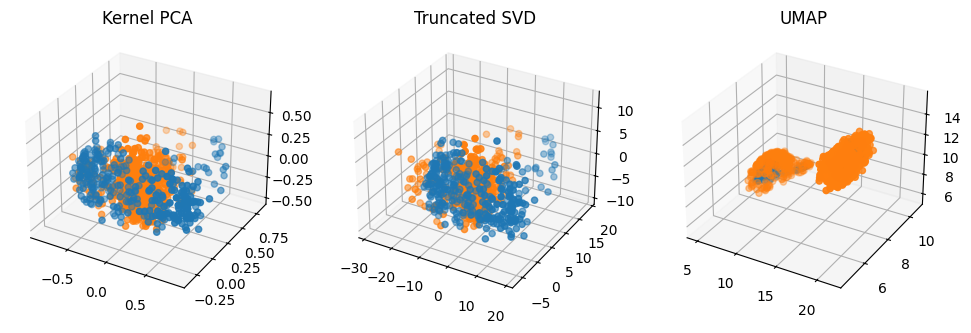

In [86]:
plot_3d(cls_embs, None)

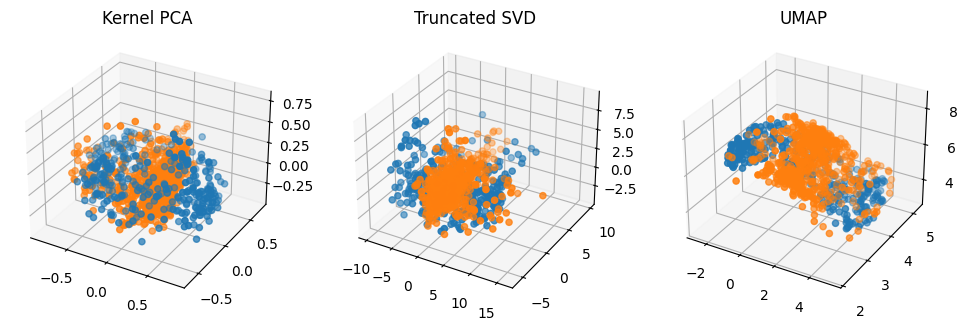

In [87]:
plot_3d(avg_embs, None)

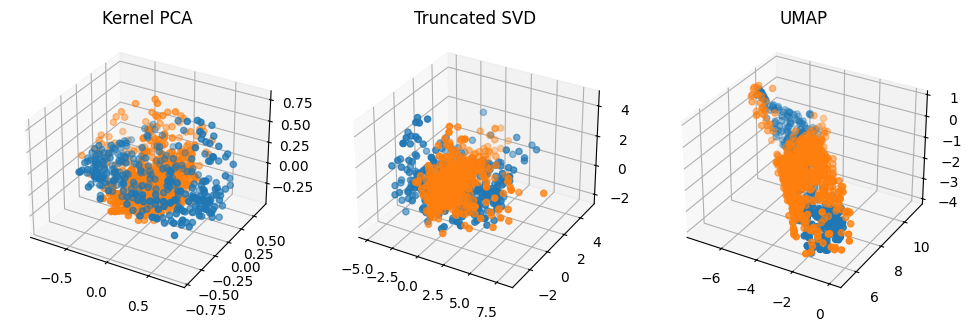

In [88]:
plot_3d(mul_layer_embs, None)

### MRPC

In [56]:
model = RobertaForSequenceClassification.from_pretrained(f"models/roberta_base_mrpc_True_CLS_True_0_cluster_var/", 
                                                      output_hidden_states=True, )

In [57]:
emb_matrix = get_emb_matrix(model, tokenizer, dataset["validation"])

  0%|          | 0/408 [00:00<?, ?it/s]

In [58]:
print_stats(emb_matrix)

cls/first: 0.059, 0.036, 0.034, 0.031, 0.029,
cls/first: anisotropy class 1 -- 0.065, 0.040, 0.035, 0.034, 0.031,
cls/first: anisotropy class 0 -- 0.074, 0.046, 0.040, 0.038, 0.035,
avg_pool: 0.084, 0.051, 0.040, 0.032, 0.031,
avg_pool: anisotropy class 1 -- 0.103, 0.058, 0.041, 0.034, 0.030,
avg_pool: anisotropy class 0 -- 0.077, 0.051, 0.048, 0.039, 0.037,
mul_layer_pool: 0.081, 0.049, 0.039, 0.033, 0.030,
mul_layer_pool: anisotropy class 1 -- 0.099, 0.056, 0.040, 0.034, 0.030,
mul_layer_pool: anisotropy class 0 -- 0.075, 0.051, 0.047, 0.039, 0.037,


In [59]:
cls_embs = get_low_dim_embs(emb_matrix["cls/first"])
avg_embs = get_low_dim_embs(emb_matrix["avg_pool"])
mul_layer_embs = get_low_dim_embs(emb_matrix["mul_layer_pool"])

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


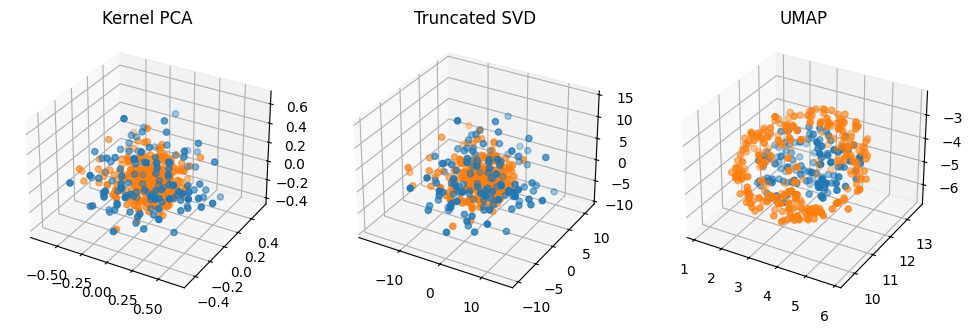

In [60]:
plot_3d(cls_embs, None)

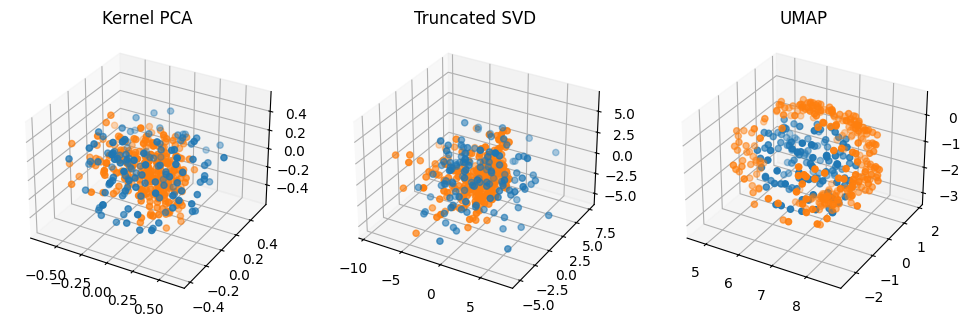

In [61]:
plot_3d(avg_embs, None)

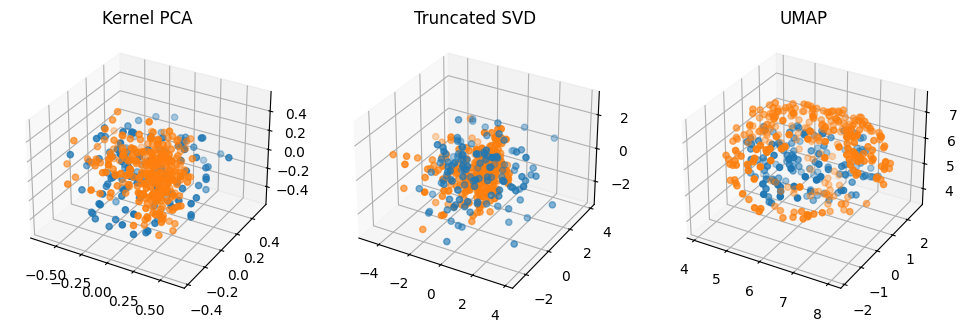

In [62]:
plot_3d(mul_layer_embs, None)

### MRPC L2 only

In [30]:
model = RobertaForSequenceClassification.from_pretrained(f"../IsoBert/models/roberta_base_mrpc_True_CLS_True_0_l2_only/", 
                                                      output_hidden_states=True, )

In [31]:
emb_matrix = get_emb_matrix(model, tokenizer, dataset["validation"])

  0%|          | 0/408 [00:00<?, ?it/s]

In [32]:
print_stats(emb_matrix)

cls/first: 0.026, 0.024, 0.023, 0.022, 0.022,
cls/first: anisotropy class 1 -- 0.028, 0.026, 0.025, 0.024, 0.023,
cls/first: anisotropy class 0 -- 0.037, 0.034, 0.032, 0.031, 0.027,
avg_pool: 0.027, 0.026, 0.024, 0.023, 0.023,
avg_pool: anisotropy class 1 -- 0.029, 0.028, 0.026, 0.025, 0.024,
avg_pool: anisotropy class 0 -- 0.039, 0.036, 0.034, 0.031, 0.029,
mul_layer_pool: 0.027, 0.025, 0.024, 0.023, 0.022,
mul_layer_pool: anisotropy class 1 -- 0.029, 0.028, 0.026, 0.025, 0.024,
mul_layer_pool: anisotropy class 0 -- 0.038, 0.036, 0.034, 0.031, 0.029,


In [33]:
cls_embs = get_low_dim_embs(emb_matrix["cls/first"])
avg_embs = get_low_dim_embs(emb_matrix["avg_pool"])
mul_layer_embs = get_low_dim_embs(emb_matrix["mul_layer_pool"])

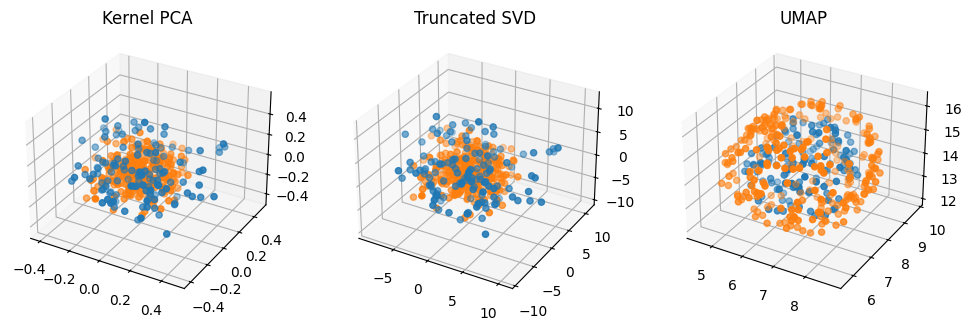

In [34]:
plot_3d(cls_embs, None)

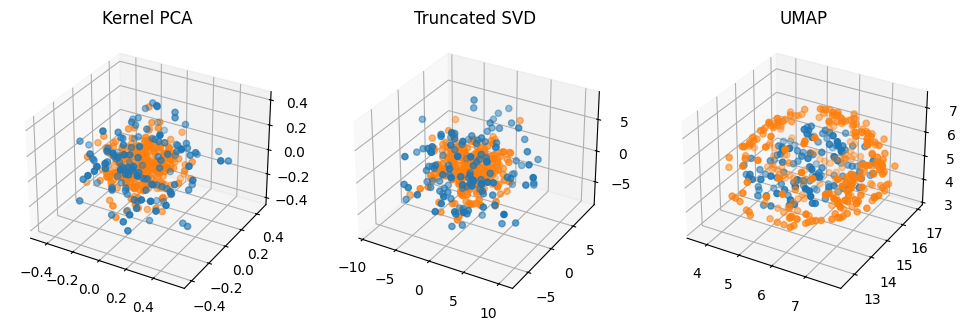

In [35]:
plot_3d(avg_embs, None)

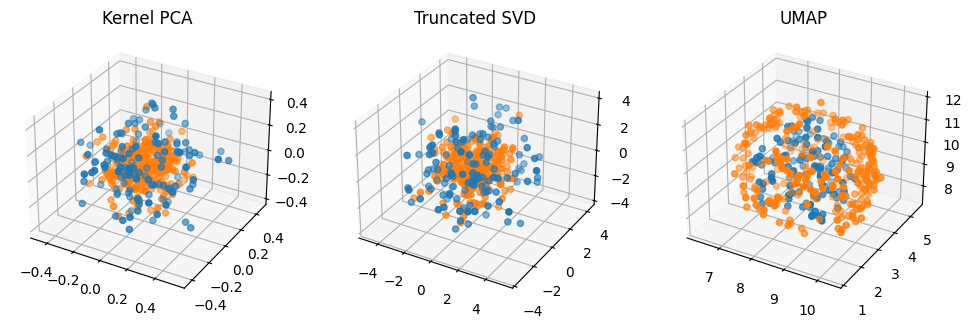

In [36]:
plot_3d(mul_layer_embs, None)